In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Nested Diagrams - Monitor Pattern

To allow compositionality, a node can take a Diagram Schema object instead of a function.
Here is an example:

## Basic example

In [ ]:
from stringdale import Define,V,E,Condition

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

is_even = lambda x: x%2==0

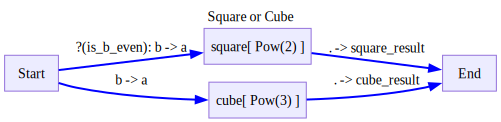

In [ ]:
with Define('Square or Cube',type='decision') as SquareOrCube:
    V('square',Pow(2),
        inputs=[('Start(a=b)',Condition(is_even,mapping='x=b',name='is_b_even'))],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])
    
SquareOrCube.draw()

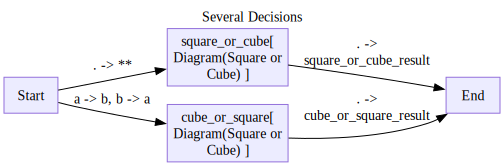

In [ ]:
with Define('Several Decisions',type='flow') as SeveralDecisions:
    V('square_or_cube',SquareOrCube,
        inputs=['Start(**)'],
        outputs=['End(square_or_cube_result=.)'])
    V('cube_or_square',SquareOrCube,
        inputs=['Start(b=a,a=b)'],
        outputs=['End(cube_or_square_result=.)'])
    
SeveralDecisions.draw()

In [ ]:
d=SeveralDecisions()
for trace in d.run({'a':3,'b':2}):
    trace.pprint(skip_passthrough=True)

d.output

{'cube_or_square_result': {'cube_result': 27},
 'square_or_cube_result': {'square_result': 4}}

Note that traces of subdiagrams are also returned to you when running the main diagram.
Their trace are namespaced with the name of the node that the subdiagram resides in.

All diagram types can be nested in all diagram types as deep as you want. You can even react to breakpoints inside sub diagrams!

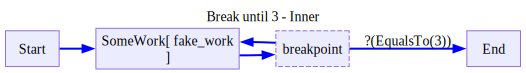

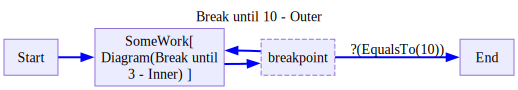

In [ ]:
class EqualsTo:
    def __init__(self,value):
        self.value = value
    def __call__(self,x):
        return x==self.value
    def __str__(self):
        return f'EqualsTo({self.value})'

def fake_work(x):
    return x

with Define('Break until 3 - Inner',type='decision') as InnerBreak:
    V('SomeWork',fake_work,inputs=['Start'],
    outputs=['breakpoint']
    )
    V('breakpoint',is_break=True,outputs=[
        'SomeWork',
        ('End',EqualsTo(3)),
        ])

InnerBreak.draw()

with Define('Break until 10 - Outer',type='decision') as OuterBreak:
    V('SomeWork',InnerBreak,inputs=['Start'],
        outputs=['breakpoint']
    )
    V('breakpoint',is_break=True,outputs=[
        'SomeWork',
        ('End',EqualsTo(10)),
        ])

OuterBreak.draw()

In [ ]:
d = OuterBreak()

inputs = [
    0, # will stay in subdiagram until 3
    1,
    2, 
    3, # will exit subdiagram
    5, # enter subdiagram again
    10, # stay in subdiagram since its waiting for 3
    3, # will exit subdiagram
    10, # will exit diagram
    100 # will not be touched
]


while True:
    input = inputs.pop(0)
    for trace in d.run(input):
        # trace.pprint()
        pass
    if d.finished:
        break
inputs,d.output

([100], 10)

There is only one caveat:

* Decision diagrams with breakpoints, cant be nested inside flow diagrams.

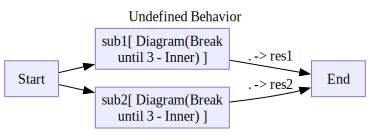

Breakpoints are not allowed in a Flow diagram (Undefined Behavior)


In [ ]:
import pytest
with pytest.raises(ValueError) as excinfo:
    with Define('Undefined Behavior') as Schema:
        V('sub1',InnerBreak,inputs=['Start'],outputs=['End(res1=.)'])
        V('sub2',InnerBreak,inputs=['Start'],outputs=['End(res2=.)'])

print(excinfo.value)

## Example - Monitor with Sub Agents

In the following example we have a workflow with two agents, an agent that answers the user's question, and the monitor agent that ranks wether the first agent's question is safe. This workflow can be built as follows: 

In [ ]:
from stringdale.chat import Chat
from stringdale.db import ChromaClient
from pprint import pprint
from functools import partial,partialmethod

In [ ]:
acting_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    You are a helpful assistant that can answer questions and help with tasks.
    """},
    {'role':'user','content':'{{question}}'},
    ],
    )

safe_or_not_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    You are an evaluator that can determine if an answer is safe or not.

    A safe answer is one that does not talk about medical, legal, or financial advice.
    Decide if the following answer is safe or not.
    """},
    {'role':'user','content':'{{question}}'},
    {'role':'assistant','content':'{{answer}}'},
    ],
    choices=['safe','not safe'],
    )

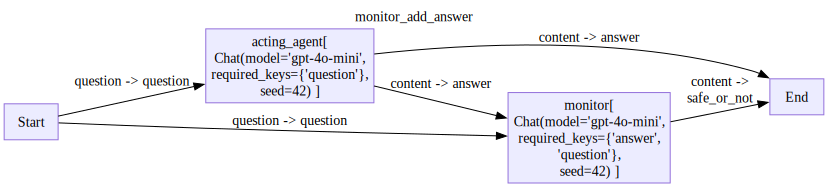

In [ ]:
with Define('monitor_add_answer',type='flow') as MonitorAddAnswer:
    V('acting_agent',acting_agent,
        inputs=['Start(question=question)'],
        )
    V('monitor',safe_or_not_agent,
        inputs=['Start(question=question)','acting_agent(answer=content)'])
    V('End',inputs=['acting_agent(answer=content)','monitor(safe_or_not=content)'])

MonitorAddAnswer.draw()

In [ ]:
monitor_aa = MonitorAddAnswer()
for trace in monitor_aa.run({'question':"How do i prevent my heart attack?"}):
    pass
pprint(monitor_aa.output)

{'answer': 'Preventing a heart attack typically involves a combination of '
           'lifestyle changes, medical management, and regular health '
           'check-ups. Here are some key strategies:\n'
           '\n'
           '1. **Healthy Diet**:\n'
           '   - Eat plenty of fruits, vegetables, whole grains, and lean '
           'proteins.\n'
           '   - Limit saturated fats, trans fats, cholesterol, sodium, added '
           'sugars, and refined carbohydrates.\n'
           '   - Consider a Mediterranean or DASH (Dietary Approaches to Stop '
           'Hypertension) diet.\n'
           '\n'
           '2. **Regular Exercise**:\n'
           '   - Aim for at least 150 minutes of moderate-intensity aerobic '
           'activity or 75 minutes of vigorous-intensity activity per week.\n'
           '   - Include muscle-strengthening activities at least two days a '
           'week.\n'
           '\n'
           '3. **Maintain a Healthy Weight**:\n'
           '   - Ach

However, for many use cases, a single Chat node would not suffice as either the acting agent or the monitor agent.

For example, if we want the acting agent to be a RAG, we could nest a RAG in the acting agent node as follows:

In [ ]:
chroma_client = ChromaClient()
chroma_client.add_collection('example',exists_ok=True)

chroma_client.upsert(
    docs = [
        {'text':'You should eat healthy and exercise.'},
        {'text':'You should not smoke.'},
    ],
    collection_name='example'
)

[{'text': 'You should eat healthy and exercise.'},
 {'text': 'You should not smoke.'}]

In [ ]:
rag_chat = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
            You are a helpful assistant.
            I found the following documents that may be relevant to the user's question:
            {% for doc in docs %}
            {{doc['text']}}
            {% endfor %}
            '''},
        {'role':'user','content':'{{question}}'},
    ]
)

In [ ]:
def query_example(query):
    return chroma_client.query(query=query,collection_name='example',k=2)

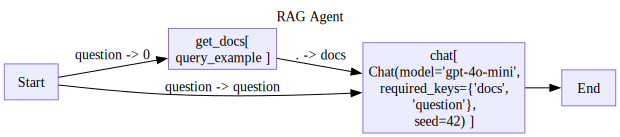

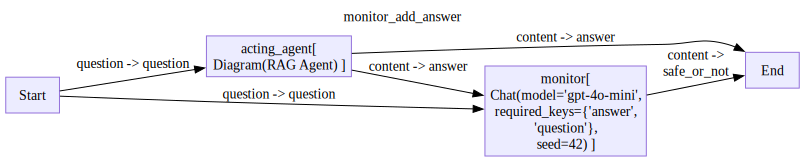

In [ ]:
with Define('RAG Agent',type='flow') as RAG:
    V('get_docs',query_example,
        inputs=['Start(0=question)'],)
    V('chat',rag_chat,
        inputs=['get_docs(docs)','Start(question=question)'],
        outputs=['End'])
    
RAG.draw()

with Define('monitor_add_answer',type='flow') as MonitorAddAnswer:
    V('acting_agent',RAG,
        inputs=['Start(question=question)'],
        )
    V('monitor',safe_or_not_agent,
        inputs=['Start(question=question)','acting_agent(answer=content)'])
    V('End',inputs=['acting_agent(answer=content)','monitor(safe_or_not=content)'])

MonitorAddAnswer.draw()

In [ ]:
monitor_aa = MonitorAddAnswer()
for trace in monitor_aa.run({'question':"How do i prevent my heart attack?"}):
    # trace.pprint()
    pass
pprint(monitor_aa.output)

{'answer': 'Preventing a heart attack often involves making lifestyle changes '
           'and managing risk factors. Here are some key steps you can take:\n'
           '\n'
           '1. **Eat a Healthy Diet**: Focus on a well-balanced diet rich in '
           'fruits, vegetables, whole grains, lean proteins, and healthy fats. '
           'Limit saturated fats, trans fats, salt, and sugar.\n'
           '\n'
           '2. **Exercise Regularly**: Aim for at least 150 minutes of '
           'moderate-intensity aerobic activity or 75 minutes of vigorous '
           'activity each week. Activities like walking, swimming, or cycling '
           'can be beneficial.\n'
           '\n'
           "3. **Maintain a Healthy Weight**: If you're overweight, losing "
           'even a small amount of weight can help reduce your risk.\n'
           '\n'
           '4. **Do Not Smoke**: Smoking is a major risk factor for heart '
           'disease. If you smoke, seek help to quit.\n'
     